In [158]:
import json
import xml.etree.ElementTree as ET
from IPython.display import SVG, display
import math
import numpy as np
from dataclasses import dataclass
from enum import Enum
from typing import Optional

In [159]:

def get_base_data():
    with open('base_data.json') as f:
        base_data = json.load(f)
    return base_data

In [160]:
@dataclass
class Dimension:
    width: int
    height: int
    
    def __mul__(self, other):
        return Dimension(self.width * other.width, self.height * other.height)
    
    def __add__(self, other):
        return Dimension(self.width + other.width, self.height + other.height)
    
    def __sub__(self, other):
        return Dimension(self.width - other.width, self.height - other.height)

@dataclass(frozen=True)
class DPoint:
    x: int
    y: int

    def __sub__(self, other):
        return DPoint(self.x - other.x, self.y - other.y)
    
    def __add__(self, other):
        return DPoint(self.x + other.x, self.y + other.y)
        
    def __repr__(self):
        return f'({self.x}, {self.y})'
    
    def scale(self, mult: Dimension, plus=Dimension(0, 0)):
        return DPoint(
            self.x * mult.width + plus.width,
            self.y * mult.height + plus.height
        )
    
    def translate(self, plus: Dimension):
        return DPoint(
            self.x + plus.width,
            self.y + plus.height
        )

In [161]:
@dataclass
class BaseInfo:
    ramp_depots: list[DPoint]
    ramp_barracks: DPoint
    start: DPoint
    region: list[DPoint]
    minerals: list[DPoint]
    geysers: list[DPoint]


def get_base_info(base_data) -> BaseInfo:
    ramp_depots = [DPoint(p[0], p[1]) for p in base_data['ramp']['corner_depots']]
    ramp_barracks = DPoint(base_data['ramp']['barracks'][0], base_data['ramp']['barracks'][1])
    start = DPoint(base_data['start'][0], base_data['start'][1])
    region = [DPoint(p[0], p[1]) for p in base_data['region']]
    minerals = [DPoint(p[0], p[1]) for p in base_data['mineral']]
    geysers = [DPoint(p[0], p[1]) for p in base_data['geysers']]
    return BaseInfo(ramp_depots, ramp_barracks, start, region, minerals, geysers)

In [162]:
def calculate_region_bounds(base_info):
    top = None
    left = None
    bottom = None
    right = None
    for p in base_info.region:
        if top is None or p.y < top:
            top = p.y
        if bottom is None or p.y > bottom:
            bottom = p.y
        if left is None or p.x < left:
            left = p.x
        if right is None or p.x > right:
            right = p.x
    return DPoint(left-1, top-1), DPoint(right+1, bottom+1)

In [163]:
def get_value_from_set(from_set, pos: DPoint, top_left: DPoint):
    rel_pos = pos - top_left
    return from_set[rel_pos.x, rel_pos.y]

def set_value_in_set(in_set, pos: DPoint, value, top_left: DPoint):
    rel_pos = pos - top_left
    in_set[rel_pos.x, rel_pos.y] = value

In [164]:
def create_svg():
    return ET.Element('svg', {'width': '550', 'height': '550'})

def show_svg(svg):
    display(SVG(ET.tostring(svg)))

In [165]:
cell_size = Dimension(15, 15)

In [166]:
class Placement(Enum):
    FIXED = 0
    MIDDLE = 1
    EDGE = 2

In [167]:


@dataclass
class Item:
    pos: Optional[DPoint]
    size: Dimension
    item_type: str
    color: str
    placement: Placement
    addon: Optional[str] = None


In [168]:
def draw_altitude(pos: DPoint, altitudes, max_altitude: int, top_left: DPoint):
    alt_color_mult = 255 / max_altitude
    alt_value = get_value_from_set(altitudes, pos, top_left)
    relative_point = pos - top_left
    scaled_point = relative_point.scale(cell_size)
    g = ET.Element('g')
    rect = ET.Element('rect', {
        'x': str(scaled_point.x),
        'y': str(scaled_point.y),
        'width': str(cell_size.width),
        'height': str(cell_size.height),
        'fill': f'rgb({alt_value*alt_color_mult}, {alt_value*alt_color_mult}, {alt_value*alt_color_mult})',
        'stroke': 'none'
    })
    g.append(rect)
    text = ET.Element('text', {
        'x': str(scaled_point.x + cell_size.width // 2),
        'y': str(scaled_point.y + cell_size.height // 2),
        'text-anchor': 'middle',
        'dominant-baseline': 'middle',
        'fill': 'red',
        'font-size': '6'
    })
    g.append(text)
    return g

def draw_item(thing: Item, top_left: DPoint):
    crop = Dimension(-top_left.x, -top_left.y) * cell_size
    half_size = thing.size * Dimension(-0.5, -0.5)
    thing_top_left = thing.pos.translate(half_size)
    scaled_top_left = thing_top_left.scale(cell_size, crop)
    scaled_center = thing.pos.scale(cell_size, crop)
    thing_size = thing.size * cell_size
    rect = ET.Element('rect', {
        'x': str(scaled_top_left.x),
        'y': str(scaled_top_left.y),
        'width': str(thing_size.width),
        'height': str(thing_size.height),
        'fill': thing.color,
        'stroke': 'white'
    })
    text = ET.Element('text', {
        'x': str(scaled_center.x),
        'y': str(scaled_center.y),
        'text-anchor': 'middle',
        'dominant-baseline': 'middle',
        'fill': 'white',

    })
    text.text = thing.item_type
    g = ET.Element('g')
    g.append(rect)
    g.append(text)
    return g

In [169]:
base_data = get_base_data()
base_info = get_base_info(base_data)

In [170]:

top_left, bottom_right = calculate_region_bounds(base_info)
region_dim = Dimension(bottom_right.x - top_left.x, bottom_right.y - top_left.y)
crop = Dimension(-top_left.x, -top_left.y) * cell_size

In [171]:
def is_within(pos: DPoint, dim: Dimension):
    return pos.x >= 0 and pos.y >= 0 and pos.x < dim.width and pos.y < dim.height

def get_neighbors(pos: DPoint, dim: Dimension):
    neighbors = [
        DPoint(pos.x-1, pos.y),
        DPoint(pos.x+1, pos.y),
        DPoint(pos.x, pos.y-1),
        DPoint(pos.x, pos.y+1),
    ]
    return [n for n in neighbors if is_within(n, dim)]

def calculate_region_set(base_info):
    region_set = np.zeros((region_dim.width, region_dim.height), dtype=np.uint8)
    region_set = np.pad(region_set, 1, constant_values=0)
    for p in base_info.region:
        rel_pos = p - top_left
        region_set[rel_pos.x, rel_pos.y] = 1
    return region_set

def region_base_set(base_info, region_set):
    base_set = np.zeros((region_dim.width, region_dim.height), dtype=np.uint8)
    base_set = np.pad(base_set, 1, constant_values=0)
    base_set.fill(255)
    # zero out positions that are zero in region_set
    base_set = np.where(region_set == 0, 0, base_set)
    
    return base_set
    

def calculate_wall_distance(base_info, region_set):
    wall_distance = region_base_set(base_info, region_set)
    
    # find borders
    borders = []
    for col_num, col in enumerate(wall_distance):
        for row_num, el in enumerate(col):
            # if it's a placeable cell
            if el == 255:
                neighbors = [
                    DPoint(col_num-1, row_num),
                    DPoint(col_num+1, row_num),
                    DPoint(col_num, row_num-1),
                    DPoint(col_num, row_num+1),
                ]
                neighbors = [n for n in neighbors if n.x >= 0 and n.y >= 0 and n.x < len(wall_distance) and n.y < len(col)]
                # if any of the neighbors is non-placable
                if any([wall_distance[n.x, n.y] == 0 for n in neighbors]):
                    wall_distance[col_num, row_num] = 1
                    borders.append(DPoint(col_num, row_num))

    # fill out altitude map starting from the borders
    current_altitude_val = 2
    current_positions = borders
    next_positions = []

    while len(current_positions) > 0:
        for p in current_positions:
            neighbors = [
                        DPoint(p.x-1, p.y),
                        DPoint(p.x+1, p.y),
                        DPoint(p.x, p.y-1),
                        DPoint(p.x, p.y+1),
                    ]
            neighbors = [n for n in neighbors if n.x >= 0 and n.y >= 0 and n.x < len(wall_distance) and n.y < len(col)]
            for n in neighbors:
                if wall_distance[n.x, n.y] > current_altitude_val:
                    wall_distance[n.x, n.y] = current_altitude_val
                    next_positions.append(n)
        current_positions = next_positions
        current_altitude_val += 1
        next_positions = []
    max_altitude = current_altitude_val
    return wall_distance, max_altitude

def area_to_positions(pos: DPoint, dim: Dimension):
    rel_pos = pos - top_left
    positions = []
    for x in range(rel_pos.x, rel_pos.x + dim.width):
        for y in range(rel_pos.y, rel_pos.y + dim.height):
            positions.append(DPoint(x, y))
    return positions

def fill_area(altitude_set, pos: DPoint, dim: Dimension):
    half_size = dim * Dimension(-0.5, -0.5)
    top_left = pos.scale(Dimension(1, 1), half_size)
    top_left = DPoint(math.floor(top_left.x), math.floor(top_left.y))
    # zero out positions that are at pos of size dim
    positions = area_to_positions(top_left, dim)

    for p in positions:
        altitude_set[p.x, p.y] = 0
    
    
    next_positions = []
    current_altitude_val = 1
    while len(positions) > 0:
        for p in positions:
            neighbors = get_neighbors(p, Dimension(altitude_set.shape[0], altitude_set.shape[1]))
            for n in neighbors:
                if altitude_set[n.x, n.y] > current_altitude_val:
                    next_positions.append(n)
                    altitude_set[n.x, n.y] = current_altitude_val
        positions = next_positions
        next_positions = []
        current_altitude_val += 1



In [172]:
def within_region(region, pos: DPoint):
    int_pos = DPoint(math.floor(pos.x), math.floor(pos.y))
    rel_pos = int_pos - top_left
    if not is_within(rel_pos, Dimension(region.shape[0], region.shape[1])):
        return False
    return region[rel_pos.x, rel_pos.y] == 1

In [189]:
def get_addon(item: Item, item_type: str):
    return Item(item.pos + DPoint(2.5, 0.5), Dimension(2,2), item_type, 'red', Placement.FIXED)

def max_point(altitude_set, condition):
    max_val = 0
    max_point = None
    for x in range(altitude_set.shape[0]):
        for y in range(altitude_set.shape[1]):
            if condition(DPoint(x, y)):
                if altitude_set[x, y] > max_val:
                    max_val = altitude_set[x, y]
                    max_point = DPoint(x, y)
    return max_point

def set_at_highest_point(altitude_set, item: Item, top_left: DPoint, condition=lambda x: True):
    argmax = max_point(altitude_set, condition)
    pos = (argmax + top_left).translate(item.size * Dimension(0.5, 0.5))
    item.pos = pos

In [216]:

region_set = calculate_region_set(base_info)
altitude, max_altitude = calculate_wall_distance(base_info, region_set)
base_info.minerals = [m for m in base_info.minerals if within_region(region_set, m)]
base_info.geysers = [g for g in base_info.geysers if within_region(region_set, g)]

main_base_items = [
    Item(base_info.start, Dimension(5, 5), 'C', 'red', Placement.FIXED),
    Item(base_info.ramp_barracks, Dimension(3, 3), 'B', 'red', Placement.FIXED),
    Item(base_info.ramp_depots[0], Dimension(2, 2), 'S1', 'red', Placement.FIXED),
    Item(base_info.ramp_depots[1], Dimension(2, 2), 'S2', 'red', Placement.FIXED),
]
main_base_items.extend([Item(m, Dimension(2, 1), '', 'blue', Placement.FIXED) for m in base_info.minerals])
main_base_items.extend([Item(g, Dimension(3, 3), 'R', 'red', Placement.FIXED) for g in base_info.geysers])

main_base_items.extend([Item(None, Dimension(3, 3), 'F', 'red', Placement.MIDDLE, 'r'),
                        Item(None, Dimension(3, 3), 'F', 'red', Placement.MIDDLE, 'r'),
                        Item(None, Dimension(3, 3), 'VS', 'red', Placement.MIDDLE, 't'),
                        Item(None, Dimension(2, 2), 'S3', 'red', Placement.EDGE),
                        Item(None, Dimension(2, 2), 'S4', 'red', Placement.EDGE),
                        Item(None, Dimension(2, 2), 'S5', 'red', Placement.EDGE),
                        Item(None, Dimension(2, 2), 'S6', 'red', Placement.EDGE),
                        Item(None, Dimension(2, 2), 'S7', 'red', Placement.EDGE),
                        Item(None, Dimension(2, 2), 'S8', 'red', Placement.EDGE),
                        Item(None, Dimension(3, 3), 'A', 'red', Placement.EDGE),
                        ])

edge_altitude = region_base_set(base_info, region_set)



for item in main_base_items:
    if item.placement == Placement.FIXED:
        fill_area(altitude, item.pos, item.size)
        fill_area(edge_altitude, item.pos, item.size)
    if item.placement == Placement.MIDDLE:
        set_at_highest_point(altitude, item, top_left)
        fill_area(altitude, item.pos, item.size)
        fill_area(edge_altitude, item.pos, item.size)
    if item.addon:
        addon = get_addon(item, item.addon)
        fill_area(altitude, addon.pos, addon.size)
        fill_area(edge_altitude, addon.pos, addon.size)
    if item.placement == Placement.EDGE:
        set_at_highest_point(edge_altitude, item, top_left, lambda x: altitude[x.x, x.y] > item.size.width // 2)
        fill_area(altitude, item.pos, item.size)
        fill_area(edge_altitude, item.pos, item.size)



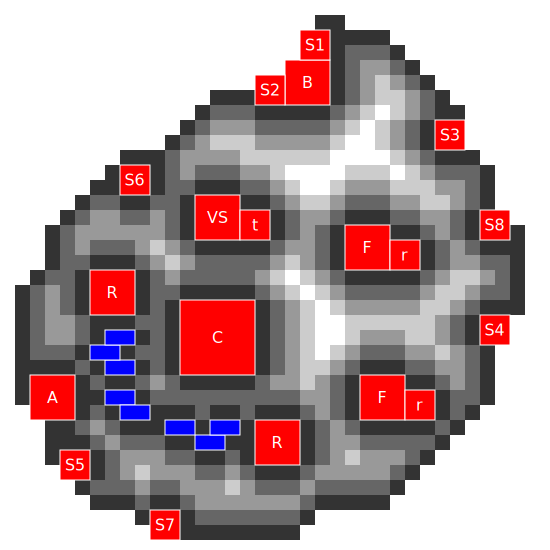

In [218]:
svg = create_svg()

max_altitude = np.max(altitude)

for pos in base_info.region:
    svg.append(draw_altitude(pos, altitude, max_altitude, top_left))

for item in main_base_items:
    svg.append(draw_item(item, top_left))
    if item.addon:
        svg.append(draw_item(get_addon(item, item.addon), top_left))

show_svg(svg)
